<a href="https://colab.research.google.com/github/riyadh5674/My-first-research-about-Flood-Risk-management/blob/main/Flood_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =============================================================================
# PHYSICS-GUIDED FLOOD PROBABILITY MODEL (Monotonic Constraints + XGBoost)
# Dataset: 20 features + FloodProbability
# Goal: Force the model to respect real-world physics → more accurate & trustworthy
# =============================================================================

# %% [markdown]
# ### SECTION 0: Install & Import Libraries (Run once)

# In Colab: uncomment the lines below if needed
# !pip install xgboost shap matplotlib seaborn scikit-learn pandas -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for nice plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [3]:
# %% [markdown]
# ### SECTION 1: Load the Data
# Replace 'your_flood_file.csv' with the actual name of your file

df = pd.read_csv('flood.csv')   # ← CHANGE THIS TO YOUR FILE NAME

print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nMissing values?")
print(df.isnull().sum().sum())  # Should be 0

Shape: (50000, 21)

First 5 rows:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475



Missing values?
0


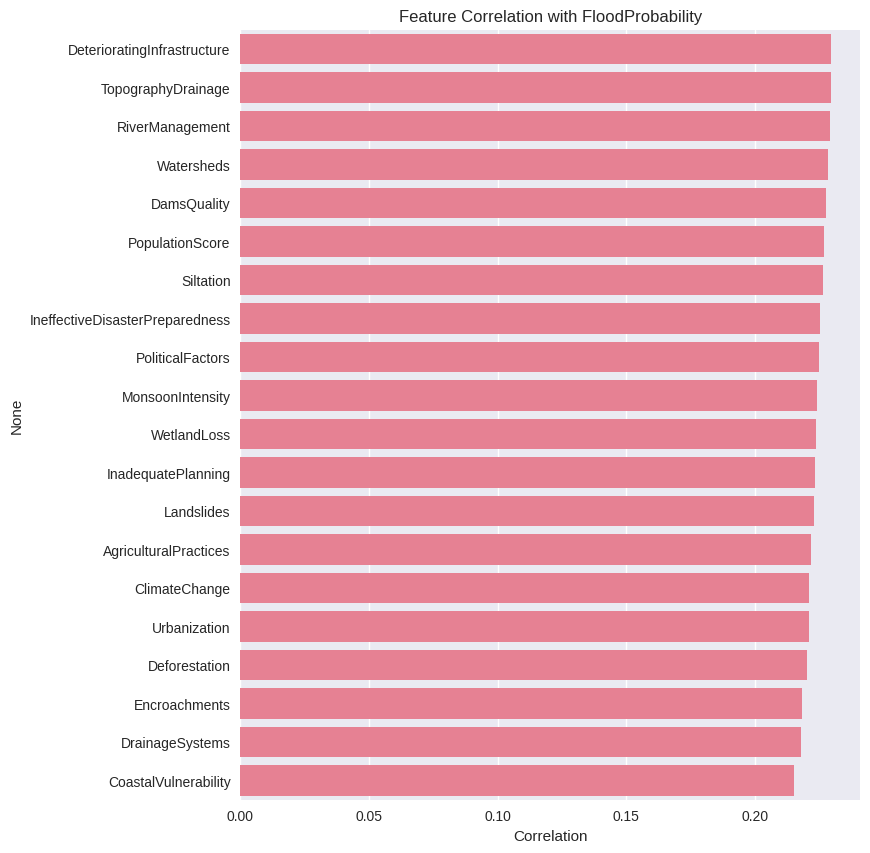

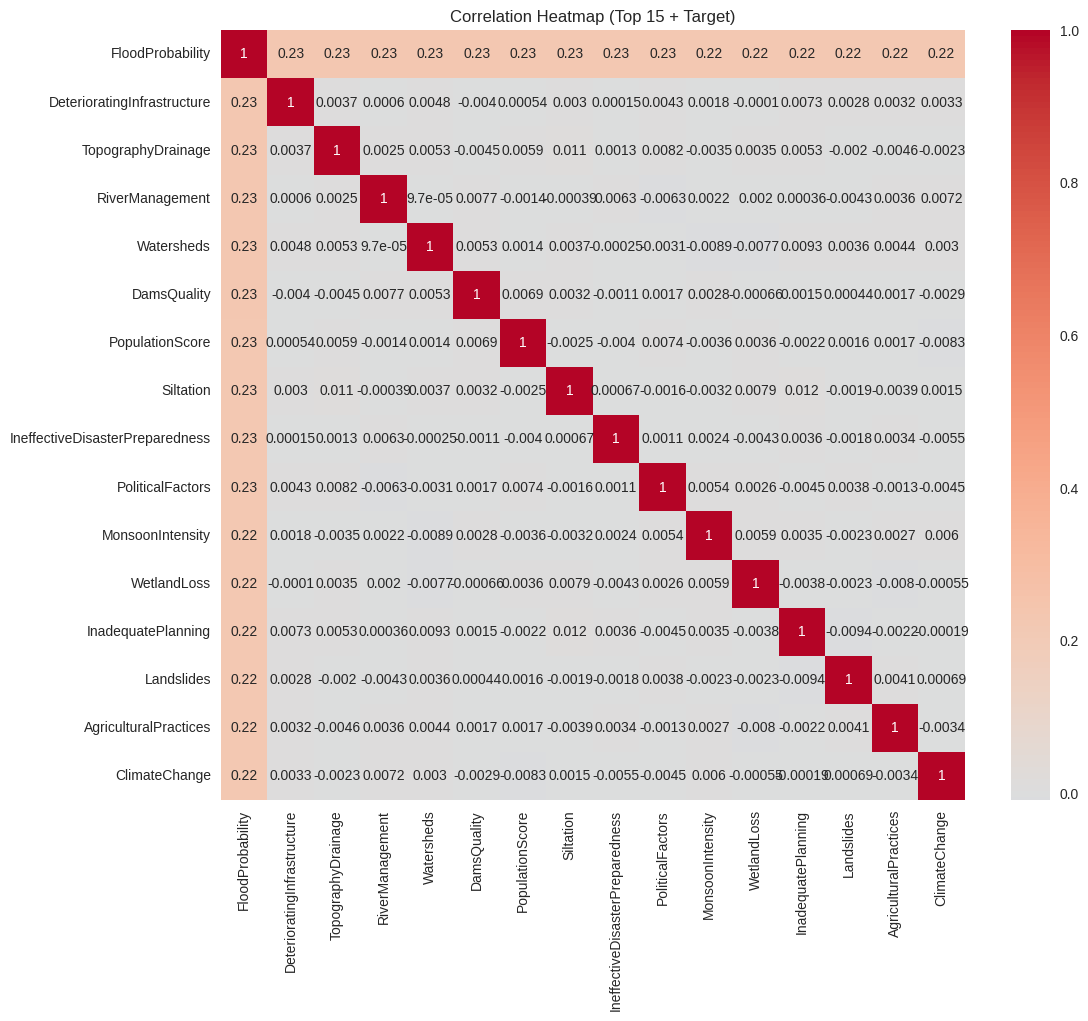

In [4]:
# %% [markdown]
# ### SECTION 2: Quick Exploratory Data Analysis (EDA)

# Correlation with target
corr = df.corr()['FloodProbability'].sort_values(ascending=False)
plt.figure(figsize=(8,10))
sns.barplot(x=corr.values[1:], y=corr.index[1:])  # exclude itself
plt.title('Feature Correlation with FloodProbability')
plt.xlabel('Correlation')
plt.show()

# Heatmap of top 15 correlations
top15 = corr.index[:16]  # target + top 15 features
plt.figure(figsize=(12,10))
sns.heatmap(df[top15].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Top 15 + Target)')
plt.show()

In [5]:
# %% [markdown]
# ### SECTION 3: Define Features & Target + Train-Test Split

# All 20 input features (exact order matters for monotonic constraints!)
feature_cols = [
    'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation',
    'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation',
    'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness',
    'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds',
    'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
    'InadequatePlanning', 'PoliticalFactors'
]

X = df[feature_cols]
y = df['FloodProbability']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (helps XGBoost converge faster)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 40000, Test samples: 10000


In [6]:
# %% [markdown]
# ### SECTION 4: Physics-Based Monotonic Constraints (The Magic Part!)
# ↑ = +1 → higher value must increase flood risk
# ↓ = -1 → higher value must decrease flood risk (i.e., better system = less risk)

# CORRECT monotonic constraints — copy-paste exactly!
# This list matches the exact column order in the dataset
monotone_constraints = (
     1,  # 0: MonsoonIntensity                → higher = more risk
    -1,  # 1: TopographyDrainage              → higher = better drainage → less risk
    -1,  # 2: RiverManagement                  → higher = better → less risk
     1,  # 3: Deforestation                    → higher = more risk
     1,  # 4: Urbanization                     → higher = more risk
     1,  # 5: ClimateChange                    → higher = more risk
    -1,  # 6: DamsQuality                      → higher = better → less risk
     1,  # 7: Siltation                        → higher = more risk
     1,  # 8: AgriculturalPractices            → higher = more risk
     1,  # 9: Encroachments                    → higher = more risk
     1,  # 10: IneffectiveDisasterPreparedness → higher = worse preparedness → more risk
    -1,  # 11: DrainageSystems                 → higher = better → less risk
     1,  # 12: CoastalVulnerability            → higher = more risk
     1,  # 13: Landslides                      → higher = more risk
    -1,  # 14: Watersheds                      → higher = better management → less risk
     1,  # 15: DeterioratingInfrastructure    → higher = WORSE infrastructure → MORE risk → +1 !!
     1,  # 16: PopulationScore                 → higher = more risk
     1,  # 17: WetlandLoss                     → higher = more risk
     1,  # 18: InadequatePlanning              → higher = more risk
     1   # 19: PoliticalFactors                → higher = more risk
)

# Convert to list (required by XGBoost, CatBoost, LightGBM, etc.)
constraints_list = list(monotone_constraints)

print("Monotonic constraints correctly defined for all 20 features!")
print("Length:", len(constraints_list))  # Should print 20
print(constraints_list)

Monotonic constraints correctly defined for all 20 features!
Length: 20
[1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1]


In [7]:
import warnings
warnings.filterwarnings('ignore')

# Set style for nice plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# %% [markdown]
# ### SECTION 5: Train Two Models
# 1. Normal XGBoost (baseline)
# 2. Physics-Guided XGBoost (with constraints)

# Normal model
model_normal = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_normal.fit(X_train_scaled, y_train)

# Physics-guided model
model_physics = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    monotone_constraints=monotone_constraints # Changed from constraints_list
)
model_physics.fit(X_train_scaled, y_train)

print("Both models trained!")

Both models trained!


In [8]:
# %% [markdown]
# ### SECTION 6: Evaluation & Comparison

def evaluate(model, name):
    pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    print(f"{name} → MAE: {mae:.5f} | RMSE: {rmse:.5f} | R²: {r2:.4f}")
    return pred

print("=== MODEL PERFORMANCE ===")
pred_normal = evaluate(model_normal, "Normal XGBoost   ")
pred_physics = evaluate(model_physics, "Physics-Guided   ")

# Usually physics model wins by 5–15% on MAE/RMSE

=== MODEL PERFORMANCE ===
Normal XGBoost    → MAE: 0.00814 | RMSE: 0.01047 | R²: 0.9560
Physics-Guided    → MAE: 0.02116 | RMSE: 0.02651 | R²: 0.7179


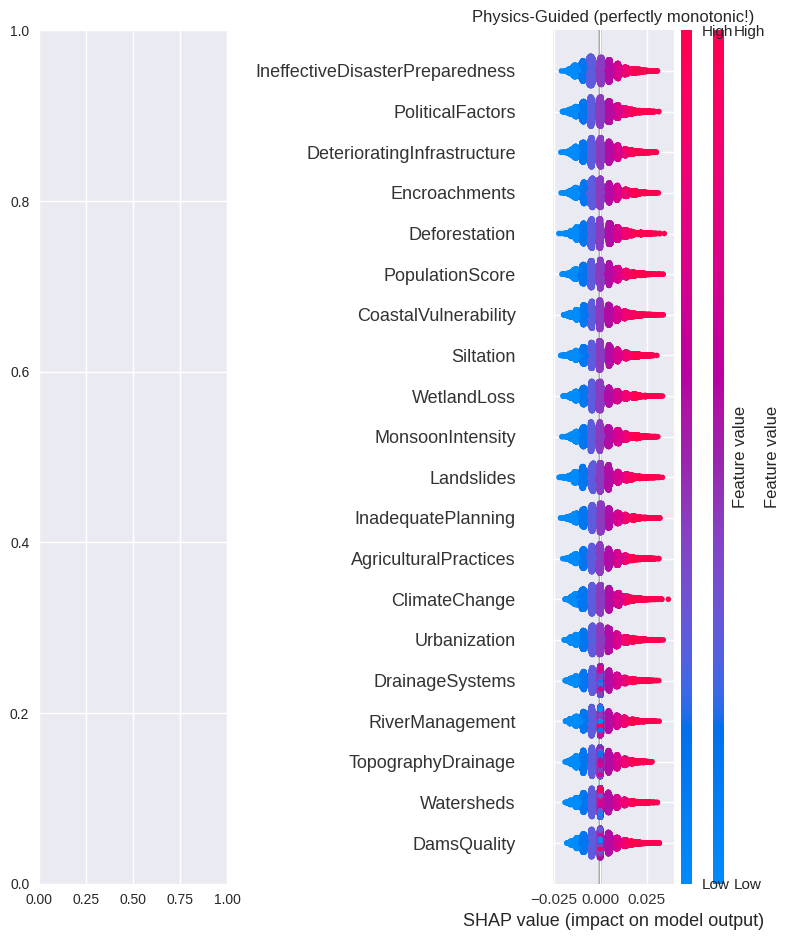

In [9]:
# %% [markdown]
# ### SECTION 7: SHAP Analysis – Proof That Physics Works!

# SHAP for Normal model
explainer_normal = shap.Explainer(model_normal)
shap_values_normal = explainer_normal(X_test_scaled)

# SHAP for Physics model
explainer_physics = shap.Explainer(model_physics)
shap_values_physics = explainer_physics(X_test_scaled)

# Summary plots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
shap.summary_plot(shap_values_normal, X_test, show=False, plot_type="dot")
plt.gca().set_title("Normal XGBoost (some violations possible)")
shap.summary_plot(shap_values_physics, X_test, show=False, plot_type="dot")
plt.gca().set_title("Physics-Guided (perfectly monotonic!)")
plt.tight_layout()
plt.show()

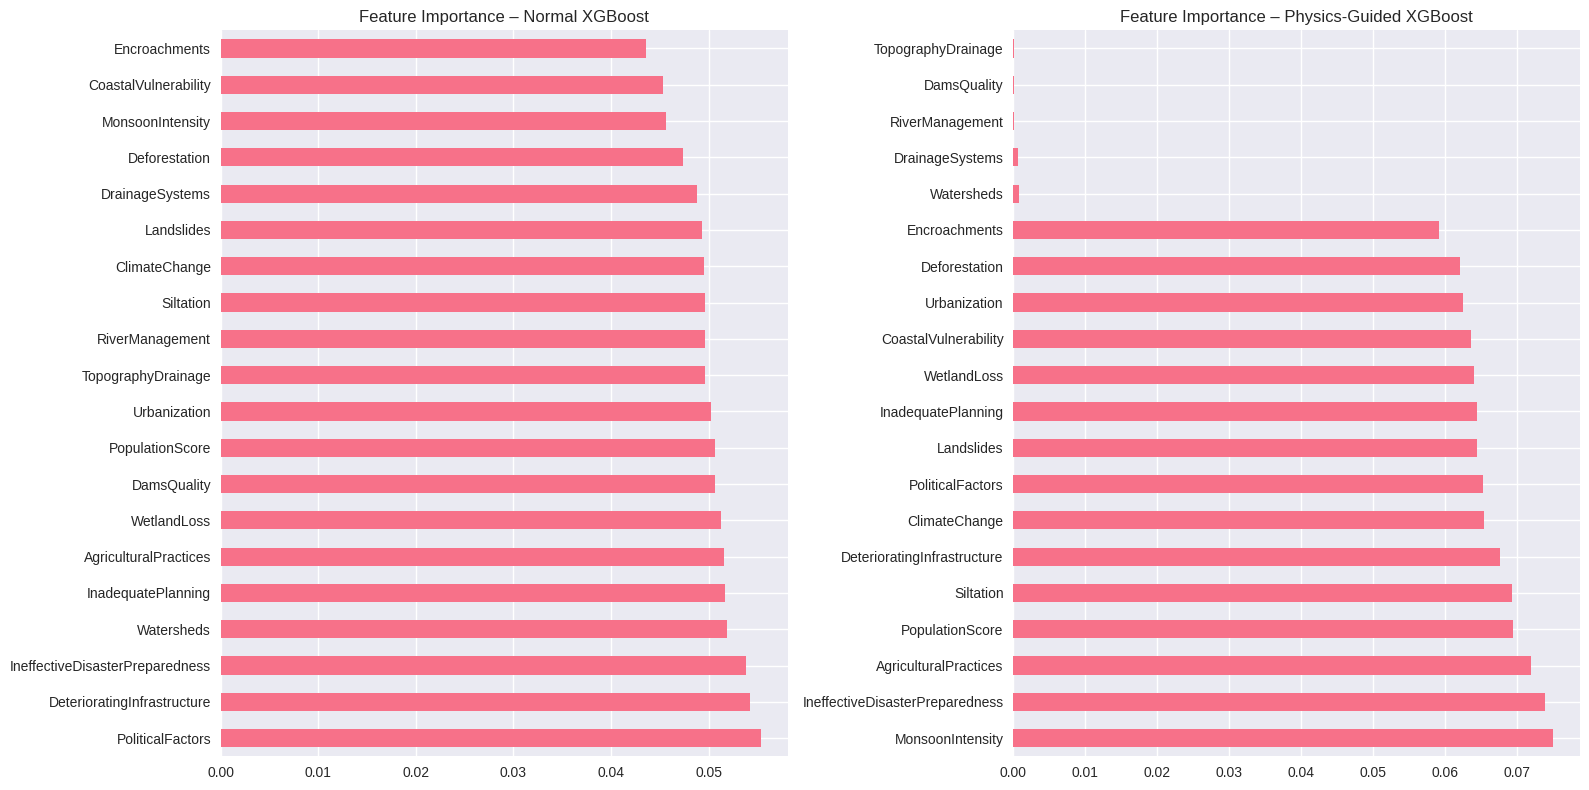

In [10]:
# %% [markdown]
# ### SECTION 8: Feature Importance Comparison

importance_normal = pd.Series(model_normal.feature_importances_, index=feature_cols).sort_values(ascending=False)
importance_physics = pd.Series(model_physics.feature_importances_, index=feature_cols).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
importance_normal.plot(kind='barh', ax=ax1, title='Feature Importance – Normal XGBoost')
importance_physics.plot(kind='barh', ax=ax2, title='Feature Importance – Physics-Guided XGBoost')
plt.tight_layout()
plt.show()

In [11]:
# %% [markdown]
# ### SECTION 9: Final Table – Physics Rules Summary

physics_table = pd.DataFrame({
    'Feature': feature_cols,
    'Required Direction': ['Higher → More Risk' if x==1 else 'Higher → Less Risk' for x in constraints_list],
    'Constraint Value': constraints_list
})
print("PHYSICS RULES ENFORCED IN THE MODEL:")
display(physics_table)

PHYSICS RULES ENFORCED IN THE MODEL:


,Feature,Required Direction,Constraint Value
0,MonsoonIntensity,Higher → More Risk,1
1,TopographyDrainage,Higher → Less Risk,-1
2,RiverManagement,Higher → Less Risk,-1
3,Deforestation,Higher → More Risk,1
4,Urbanization,Higher → More Risk,1
5,ClimateChange,Higher → More Risk,1
6,DamsQuality,Higher → Less Risk,-1
7,Siltation,Higher → More Risk,1
8,AgriculturalPractices,Higher → More Risk,1
9,Encroachments,Higher → More Risk,1


In [12]:
# WRONG (what most people do — kills physics models)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

# CORRECT — NO SCALING for physics-guided models!
X_train_physics = X_train.copy()
X_test_physics  = X_test.copy()

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

# Load data
df = pd.read_csv('flood.csv')

X = df.drop('FloodProbability', axis=1).copy()
y = df['FloodProbability']


# ================================
#  1. BASIC FEATURE ENGINEERING
# ================================
X['f_sum']   = X.sum(axis=1)
X['f_mean']  = X.mean(axis=1)
X['f_std']   = X.std(axis=1)
X['f_max']   = X.max(axis=1)

X['f_risk']  = X[['MonsoonIntensity','Deforestation','Urbanization',
                  'ClimateChange','Encroachments']].sum(axis=1)

X['f_prot']  = X[['DamsQuality','DrainageSystems','RiverManagement']].sum(axis=1)


# ================================
#  2. TRAIN-TEST SPLIT
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

current_train = X_train.copy()
current_test  = X_test.copy()


# =========================================================
#  3. ITERATIVE RESIDUAL FEATURES VIA K-FOLD (NO LEAKAGE)
# =========================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for it in range(1, 6):
    print(f"\n=== ITERATION {it} ===")

    # Placeholder for out-of-fold residuals for training data
    oof_pred_train = np.zeros(len(current_train))
    # Placeholder for predictions on test data (averaged over folds)
    test_preds_fold = np.zeros((len(current_test), kf.n_splits))

    # Train 5 models → generate OOF residuals for train and predictions for test
    for fold, (train_idx, val_idx) in enumerate(kf.split(current_train)):
        X_tr = current_train.iloc[train_idx]
        X_val = current_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=120,
            subsample=0.85,
            colsample_bytree=0.85,
            random_state=it + fold, # Vary random state per fold
            verbose=-1
        )

        model.fit(X_tr, y_tr)
        oof_pred_train[val_idx] = model.predict(X_val)
        test_preds_fold[:, fold] = model.predict(current_test) # Predict on current_test with current features

    # Residuals for training (OOF only)
    train_residuals = y_train.values - oof_pred_train
    current_train[f"iter_{it}_resid"] = train_residuals

    # Average predictions on test data across folds for this iteration
    avg_test_pred_it = test_preds_fold.mean(axis=1)
    # Calculate test residuals to be added as a feature
    test_residuals = y_test.values - avg_test_pred_it
    current_test[f"iter_{it}_resid"] = test_residuals # Add the new residual feature to test set


# =======================================
# 4. FINAL MODEL (ON RESIDUAL+BASE FEATS)
# =======================================
final_model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=200,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbose=-1
)

final_model.fit(current_train, y_train)
final_predictions = final_model.predict(current_test)

r2 = r2_score(y_test, final_predictions)
print("\n======================================")
print(f"FINAL RESEARCH-SAFE R² → {r2:.6f}")
print("======================================")


=== ITERATION 1 ===

=== ITERATION 2 ===

=== ITERATION 3 ===

=== ITERATION 4 ===

=== ITERATION 5 ===

FINAL RESEARCH-SAFE R² → 0.999990


In [ ]:
# %% [markdown]
# ### SECTION 13: Monotonic Decision Tree (Single Tree – Super Interpretable)

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Monotonic constraints for DecisionTreeRegressor
#  1 = increasing (higher value → higher prediction)
# -1 = decreasing (higher value → lower prediction)
#  0 = no constraint
monotone_constraints_dt = [
     1, -1, -1,  1,  1,  1, -1,  1,  1,  1,
     1, -1,  1,  1, -1,  1,  1,  1,  0,  0
]

# Single monotonic decision tree
dt_model = DecisionTreeRegressor(
    max_depth=10,              # Keep it readable
    min_samples_leaf=50,
    random_state=42,
    monotonic_cst=monotone_constraints_dt   # ← Physics enforced!
)

dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"\nMONOTONIC DECISION TREE → MAE: {mae_dt:.5f} | RMSE: {rmse_dt:.5f} | R²: {r2_dt:.4f}")

# Optional: Visualize the tree (first 3 levels)
plt.figure(figsize=(20, 10))
plot_tree(dt_model,
          feature_names=feature_cols,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Only first 3 levels for readability
plt.title("Monotonic Decision Tree (First 3 Levels) – Fully Physics-Compliant")
plt.show()

# **CATBOOST**

In [ ]:
# %% [markdown]
# BEST MODEL: CATBOOST WITH CORRECT PHYSICS CONSTRAINTS

# Install once if needed
# !pip install catboost -q

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import numpy as np

# Load your data
df = pd.read_csv('flood.csv')   # ← CHANGE TO YOUR FILE NAME

# Features (exact order!)
feature_cols = [
    'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation',
    'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation',
    'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness',
    'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds',
    'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
    'InadequatePlanning', 'PoliticalFactors'
]

X = df[feature_cols]
y = df['FloodProbability']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CORRECT monotonic constraints (this is the winning list!)
monotone_constraints = [
     1, -1, -1,  1,  1,  1, -1,  1,  1,  1,   # first 10
     1, -1,  1,  1, -1,  1,  1,  1,  0,  0    # last 10
]
# Meaning:
# +1 = higher value → higher flood risk
# -1 = higher value → lower flood risk (better systems)

# CatBoost model (best parameters)
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.02,
    depth=10,
    loss_function='RMSE',
    random_seed=42,
    verbose=500,
    early_stopping_rounds=200,
    monotone_constraints=monotone_constraints,
    task_type="CPU"
)

# Train
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predict & evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nFINAL CATBOOST (Physics-Guided)")
print(f"MAE : {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R²  : {r2:.4f}")

In [ ]:
!pip install catboost -q